# Data Mining CHEmBL dataset for Drug Discovery applications (QSAR)

## Background information on Drug Discovery


Database : CHEmBL [[1]](https://www.ebi.ac.uk/chembl/) <br>
Disease : Alzheimer
Target Protein : amyloid-beta <br>

## Import The dataset from the Website using API

In [ ]:
!pip install chembl_webresource_client

     |████████████████████████████████| 55 kB 2.3 MB/s 
     |████████████████████████████████| 636 kB 11.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: itsdangerous
    Found existing installation: itsdangerous 1.1.0
    Uninstalling itsdangerous-1.1.0:
      Successfully uninstalled itsdangerous-1.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires itsdangerous<2.0,>=0.24, but you have itsdangerous 2.0.1 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
from chembl_webresource_client.new_client import new_client
# search for the Disease
target = new_client.target
target_query = target.search('Alzheimer') # dtype of target_query is dictionary
targets=pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Homo sapiens,Nucleosome-remodeling factor subunit BPTF,12.0,False,CHEMBL3085621,"[{'accession': 'Q12830', 'component_descriptio...",SINGLE PROTEIN,9606
1,[],Rattus norvegicus,Amyloid beta A4 protein,5.0,False,CHEMBL3638365,"[{'accession': 'P08592', 'component_descriptio...",SINGLE PROTEIN,10116
2,"[{'xref_id': 'P05067', 'xref_name': None, 'xre...",Homo sapiens,Beta amyloid A4 protein,4.0,False,CHEMBL2487,"[{'accession': 'P05067', 'component_descriptio...",SINGLE PROTEIN,9606
3,[],Mus musculus,Amyloid-beta A4 protein,4.0,False,CHEMBL4523942,"[{'accession': 'P12023', 'component_descriptio...",SINGLE PROTEIN,10090


In [ ]:
# select the Target Protein associated with the disease "Alzheimer" by index
target_selected = targets.target_chembl_id[2]
target_selected

'CHEMBL2487'

In [ ]:
# retrieve bioactivity of only the protein we choose with the id and  standard type = IC50
activity = new_client.activity
res = activity.filter(target_chembl_id= target_selected).filter(standard_type="IC50")
#create a dataframe from the dictionary
df = pd.DataFrame.from_dict(res)

In [ ]:
#Explore the data we have
print(df.shape)
print(df.head())
print(df.info())

(1245, 45)
  activity_comment  activity_id  ... upper_value value
0             None       357577  ...        None   5.0
1             None       357580  ...        None   2.7
2             None       358965  ...        None   1.8
3             None       368887  ...        None  11.0
4             None       375954  ...        None  10.0

[5 rows x 45 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1245 entries, 0 to 1244
Data columns (total 45 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   activity_comment           284 non-null    object
 1   activity_id                1245 non-null   int64 
 2   activity_properties        1245 non-null   object
 3   assay_chembl_id            1245 non-null   object
 4   assay_description          1245 non-null   object
 5   assay_type                 1245 non-null   object
 6   assay_variant_accession    0 non-null      object
 7   assay_variant_mutation     0 

In [ ]:
# make sure that all rows have standard_type as IC50 and not any derivatives of it
# Note the lower the standard value the better cuz high values means we need to increase the dosage of the medicine 
# =====> always choose the row with the smallest dosage  
df.standard_value= pd.to_numeric(df.standard_value) # ic50 needs to be float
df.standard_value.describe()

count      1117.000000
mean      19952.229857
std       55072.527622
min          -5.000000
25%         180.000000
50%        4600.000000
75%       16500.000000
max      800000.000000
Name: standard_value, dtype: float64

In [ ]:
#Save my extracted data into a .csv file with index = false aka dont put the first column as indexing for the records
df.to_csv('QSAR_Alzheimer1.csv', index=False)
#mount the file to google drive so its avaible all the time
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# load the content from colab to google drive folders
#------------------------------------------------------
# make folder for data
! mkdir '/content/gdrive/MyDrive/Colab Notebooks/data'
#copy the data from colab to gdrive
! cp "QSAR_Alzheimer.csv" '/content/gdrive/MyDrive/Colab Notebooks/data'

mkdir: cannot create directory ‘/content/gdrive/MyDrive/Colab Notebooks/data’: File exists
cp: cannot stat 'QSAR_Alzheimer.csv': No such file or directory


In [ ]:
! ls

gdrive	QSAR_Alzheimer1.csv  sample_data


## Preprocessing 

### Cleaning data

**1. Handling missing data && duplicates .. from canonical_smiles column**

In [ ]:
#Handling the missing data
df=df.dropna(subset=['standard_value', 'canonical_smiles'])
#print(df.shape)
df = df.drop_duplicates(['canonical_smiles']).reset_index(drop=True)
#print(df.shape)

**2. Feature Selection &Simplifying the molecular smile notation**

In [ ]:
# NOTE I am cleaning , by removing insignificant element and keeping the largest compound in each SMILES expression
selected_features=["molecule_chembl_id", "canonical_smiles", "standard_value"]
df = df[selected_features]

smileless= df.drop(columns=['canonical_smiles'])

smiles=[]
for i in df['canonical_smiles'].tolist():
  strg= str(i).split(".")
  strg = max(strg,key= len)
  smiles.append(strg)

smiles=pd.DataFrame(data=smiles, columns=["canonical_smiles"])
df = pd.concat([smileless, smiles], axis=1)

**3. Removing gross error in IC50 values** <br>
REASON : no concentration can exists in negative value <br>
SOLUTION : apply absolute function on all ic50 values<br>

In [ ]:
df_without_ic50=df.drop(columns=['standard_value'])
ic50=[]
for i in df['standard_value']:
  if float(i) < 0:
    print(i)
    ic50.append(abs(i))
  else:
    ic50.append(i)
ic50=pd.DataFrame(data=ic50, columns=["standard_value"])
df = pd.concat([df_without_ic50, ic50], axis=1)

-1.0


In [ ]:
df["standard_value"].describe()

count       939.000000
mean      20810.671672
std       57975.111864
min           0.300000
25%         123.500000
50%        3700.000000
75%       16905.000000
max      800000.000000
Name: standard_value, dtype: float64

**4. Binded feature that classifies the bioacitvity**<br>
*based on weight in nano molar*<br>
- active : x <= 1000 nMolar 
- inactive : x >= 10000 nMolar
- intermediate (noise) : x> 1000 nMolar and x < 10000 nMolar

In [ ]:
bioactivity_class=[] 
for i in df['standard_value']:
  if float(i) <= 1000:
    bioactivity_class.append("active")
  elif float(i) >= 10000:
    bioactivity_class.append("inactive")
  else:
    bioactivity_class.append("intermediate")
act_series=pd.Series(bioactivity_class, name="class")
df = pd.concat([df, act_series], axis=1)
#df=df[df['class'] != 'intermediate']

**SAVE THE PREPROCESSED FILE AKA ANTHER CHECKPOINT**

## Perform Exploratory Data Analysis (EDA)

### Create meaningful features to do EDA on it

**install conda then RDKit**<br>
*conda is part of RDKit thus I have to have conda to install/run RDKit*
- RDKit is open source library for processing chemical structures of molecules and apply chemistry-related calulation

In [ ]:
# install the conda and RDKit libraries
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2021-09-26 11:02:12--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   190MB/s    in 0.4s    

2021-09-26 11:02:12 (190 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h

In [ ]:
# import RDKit modules needed : Chem , discriptor and lipinski
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

**Calculate the Lipinski Descriptor**

In [ ]:
def lipinski(smiles, verbose=False):
  moldata=[]
  for element in smiles:
    # get all molecules from the smiles
    mol=Chem.MolFromSmiles(element)
    moldata.append(mol)
    basedata = np.arange(1,1)
  i = 0
  for mol in moldata:
    # calculate the molecule weight
    molWt = Descriptors.MolWt(mol)
    # calculate the molecule log-p
    molLogP = Descriptors.MolLogP(mol)
    # calculate the molecule h bond donor
    molHBD = Lipinski.NumHDonors(mol)
    # calculate the molecule h bond acceptor
    molHBA = Lipinski.NumHAcceptors(mol)
    # put all as a row
    row = np.array([molWt, molLogP, molHBD, molHBA])
    if i == 0:
      basedata=row
    else: ##i dont understand a word from this else statement .... like what are the cases where i execute else ???
      basedata = np.vstack([basedata,row])
      #vstack is a data structure stack (FIFO)
    i = i+1
  columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
  descriptors = pd.DataFrame(data=basedata,columns=columnNames)
  return descriptors

In [ ]:
df_lipinski = lipinski(smiles=df['canonical_smiles'])
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,311.422,3.31880,1.0,2.0
1,299.461,3.24120,1.0,3.0
2,311.422,3.31880,1.0,2.0
3,327.877,3.83310,1.0,2.0
4,372.328,3.94220,1.0,2.0
...,...,...,...,...
934,328.496,6.36792,2.0,2.0
935,514.483,4.66972,0.0,7.0
936,496.493,4.53062,0.0,7.0
937,517.925,4.66920,1.0,4.0


In [ ]:
# merge the dataframes into the main dataframe aka df
df = pd.concat([df,df_lipinski], axis=1)
df

,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL311039,CC12CCC(C1)C(C)(C)C2NS(=O)(=O)c1ccc(F)cc1,5000.0,intermediate,311.422,3.31880,1.0,2.0
1,CHEMBL450926,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1cccs1,2700.0,intermediate,299.461,3.24120,1.0,3.0
2,CHEMBL310242,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,1800.0,intermediate,311.422,3.31880,1.0,2.0
3,CHEMBL74874,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,11000.0,inactive,327.877,3.83310,1.0,2.0
4,CHEMBL75183,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,10000.0,inactive,372.328,3.94220,1.0,2.0
...,...,...,...,...,...,...,...,...
934,CHEMBL4641877,CC(C)=CCC/C(C)=C/CC/C(C)=C/Cc1c(C)cc(O)cc1O,19900.0,inactive,328.496,6.36792,2.0,2.0
935,CHEMBL3609637,COc1cc(-c2cn(C3CCc4c(F)cccc4N(CC(F)(F)F)C3=O)n...,31.0,active,514.483,4.66972,0.0,7.0
936,CHEMBL4534005,COc1cc(-c2cn(C3CCc4ccccc4N(CC(F)(F)F)C3=O)nn2)...,10.0,active,496.493,4.53062,0.0,7.0
937,CHEMBL1091513,O=S(=O)(NC1CCC(c2cc(F)ccc2F)(S(=O)(=O)c2ccc(Cl...,0.5,active,517.925,4.66920,1.0,4.0


**Convert the standard from IC50 to pIC50**
<hr>
step 1 : create pIC50 column ( func= -log(IC50) )<br>
NOTE : cap the values to log10 (<= 0 have log10(-) which is UNDEFINED) <br>
step 2 : replace standard_Value column with it <br>
step 3 : (*optioanl*) illustrate with the scatered plot the diff of distrubution btw IC50 and pIC50 <br>

In [ ]:
print(df.standard_value.describe())
IC50 = df['standard_value']

count       939.000000
mean      20810.671672
std       57975.111864
min           0.300000
25%         123.500000
50%        3700.000000
75%       16905.000000
max      800000.000000
Name: standard_value, dtype: float64


In [ ]:
#Note the standard value of IC50 is in nano Moles (nM) => convert to M before claculating the pIC50
def pIC50(data):
  pIC50=[]
  for ic50 in data['standard_value']:
    if float(ic50) <= 0:
      ic50= 10e-8
    ic50 = float(ic50) * (10**-9)
    pIC50.append(-np.log10(ic50))
  IC50 = data['standard_value']

  df=data.drop(columns=['standard_value'],axis=1)

  pIC50_series= pd.Series(data=pIC50, name="pIC50")
  df_edited =pd.concat([data,pIC50_series],axis=1)
  return df_edited

In [ ]:
df

,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL311039,CC12CCC(C1)C(C)(C)C2NS(=O)(=O)c1ccc(F)cc1,5000.0,intermediate,311.422,3.31880,1.0,2.0
1,CHEMBL450926,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1cccs1,2700.0,intermediate,299.461,3.24120,1.0,3.0
2,CHEMBL310242,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,1800.0,intermediate,311.422,3.31880,1.0,2.0
3,CHEMBL74874,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,11000.0,inactive,327.877,3.83310,1.0,2.0
4,CHEMBL75183,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,10000.0,inactive,372.328,3.94220,1.0,2.0
...,...,...,...,...,...,...,...,...
934,CHEMBL4641877,CC(C)=CCC/C(C)=C/CC/C(C)=C/Cc1c(C)cc(O)cc1O,19900.0,inactive,328.496,6.36792,2.0,2.0
935,CHEMBL3609637,COc1cc(-c2cn(C3CCc4c(F)cccc4N(CC(F)(F)F)C3=O)n...,31.0,active,514.483,4.66972,0.0,7.0
936,CHEMBL4534005,COc1cc(-c2cn(C3CCc4ccccc4N(CC(F)(F)F)C3=O)nn2)...,10.0,active,496.493,4.53062,0.0,7.0
937,CHEMBL1091513,O=S(=O)(NC1CCC(c2cc(F)ccc2F)(S(=O)(=O)c2ccc(Cl...,0.5,active,517.925,4.66920,1.0,4.0


In [ ]:
df=pIC50(df)
df.shape
df.pIC50.describe()

count    939.000000
mean       5.806190
std        1.344742
min        3.096910
25%        4.771992
50%        5.431798
75%        6.908337
max        9.522879
Name: pIC50, dtype: float64

**Remove the intermediate activity class row and save it**


In [ ]:
df=df[df['class'] != 'intermediate']
df.to_csv('QSAR_Alzheimer_ready_for_EDA.csv', index=False)

### Exploratory Data Analysis (EDA)

In [ ]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

***Frequency plot of the 2 bioactivity classes***

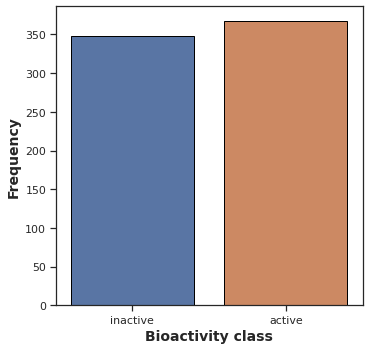

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

***Scatter plot of MW versus LogP***

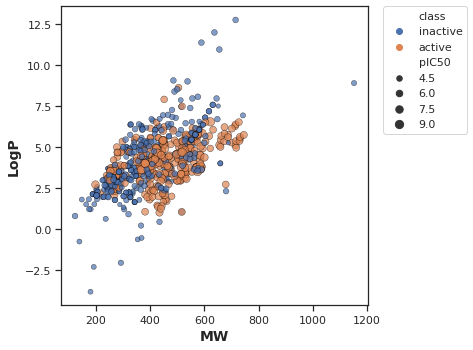

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

**Box plots** <br>
pIC50 value

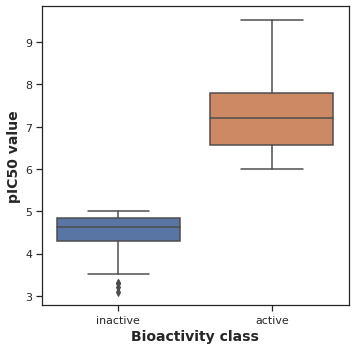

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'pIC50', data = df)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')


**MW**

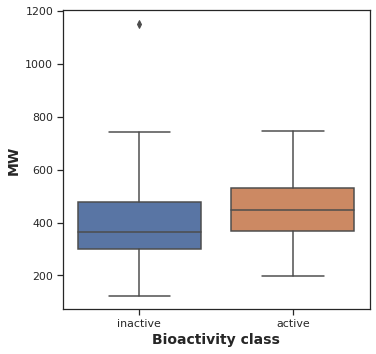

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', data = df)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

**LogP**

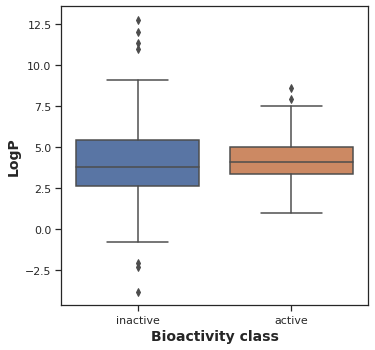

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

**NumHDonors**

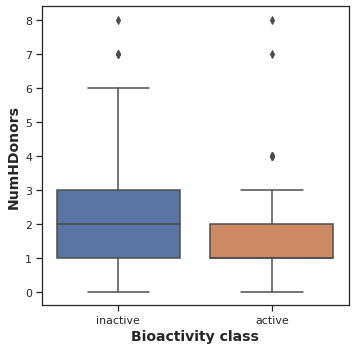

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

**NumHAcceptors**

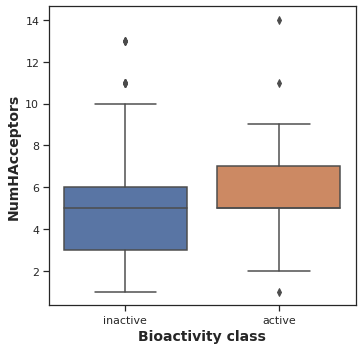

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

## Feature Engineering 
*calculate the paddle discriptor*


- download **padel.zip** and **padel.sh** from github downloadable links
- upzip the zip file
- create a dataframe with canonical_smiles and molecule_id
- save the file to csv without header or index as <u>**[ .smi ]**</u>  file
- run the .sh file using bash command
- concat the output file from the padel.sh with the pIC50 values

In [ ]:
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip

--2021-09-26 11:03:29--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip [following]
--2021-09-26 11:03:29--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25768637 (25M) [application/zip]
Saving to: ‘padel.zip’

padel.zip           100%[===================>]  24.57M   157MB/s    in 0.2s    

2021-09-26 11:03:30 (157 MB/s) - ‘padel.zip’ saved [25768637/25768637]



In [ ]:
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

--2021-09-26 11:03:30--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.sh [following]
--2021-09-26 11:03:30--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231 [text/plain]
Saving to: ‘padel.sh’

padel.sh            100%[===================>]     231  --.-KB/s    in 0s      

2021-09-26 11:03:30 (10.4 MB/s) - ‘padel.sh’ saved [231/231]



In [ ]:
! unzip padel.zip

Archive:  padel.zip
   creating: PaDEL-Descriptor/
  inflating: __MACOSX/._PaDEL-Descriptor  
  inflating: PaDEL-Descriptor/MACCSFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._MACCSFingerprinter.xml  
  inflating: PaDEL-Descriptor/AtomPairs2DFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._AtomPairs2DFingerprinter.xml  
  inflating: PaDEL-Descriptor/EStateFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._EStateFingerprinter.xml  
  inflating: PaDEL-Descriptor/Fingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._Fingerprinter.xml  
  inflating: PaDEL-Descriptor/.DS_Store  
  inflating: __MACOSX/PaDEL-Descriptor/._.DS_Store  
   creating: PaDEL-Descriptor/license/
  inflating: __MACOSX/PaDEL-Descriptor/._license  
  inflating: PaDEL-Descriptor/KlekotaRothFingerprintCount.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._KlekotaRothFingerprintCount.xml  
  inflating: PaDEL-Descriptor/config  
  inflating: __MACOSX/PaDEL-Descriptor/._config  
  inf

In [ ]:
selection = ['canonical_smiles','molecule_chembl_id']
df3_selection = df[selection]
df3_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)
df['pIC50'].to_csv('output.csv', index=False)

In [ ]:
! cat molecule.smi | head -5
! cat molecule.smi | wc -l

CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(Cl)cc1	CHEMBL74874
CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(Br)cc1	CHEMBL75183
CC(C(=O)O)c1ccc(-c2ccccc2)c(F)c1	CHEMBL563
CC(C(=O)O)c1ccc(-c2ccc(Cl)c(Cl)c2)c(F)c1	CHEMBL196279
CC(C(=O)O)c1ccc(-c2cc(Cl)cc(Cl)c2)c(F)c1	CHEMBL195970
716


Calculate fingerprint descriptors<br>
Calculate PaDEL descriptors <br>


In [ ]:
! cat padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


In [ ]:
! bash padel.sh

Processing CHEMBL74874 in molecule.smi (1/716). 
Processing CHEMBL75183 in molecule.smi (2/716). 
Processing CHEMBL196279 in molecule.smi (4/716). Average speed: 1.81 s/mol.
Processing CHEMBL563 in molecule.smi (3/716). Average speed: 3.54 s/mol.
Processing CHEMBL264006 in molecule.smi (6/716). Average speed: 1.62 s/mol.
Processing CHEMBL195970 in molecule.smi (5/716). Average speed: 1.61 s/mol.
Processing CHEMBL193971 in molecule.smi (7/716). Average speed: 1.16 s/mol.
Processing CHEMBL194274 in molecule.smi (8/716). Average speed: 1.09 s/mol.
Processing CHEMBL196321 in molecule.smi (9/716). Average speed: 0.97 s/mol.
Processing CHEMBL196322 in molecule.smi (10/716). Average speed: 0.91 s/mol.
Processing CHEMBL380778 in molecule.smi (11/716). Average speed: 0.84 s/mol.
Processing CHEMBL197202 in molecule.smi (12/716). Average speed: 0.82 s/mol.
Processing CHEMBL194760 in molecule.smi (13/716). Average speed: 0.87 s/mol.
Processing CHEMBL196246 in molecule.smi (14/716). Average speed: 

Preparing the X and Y Data Matrices<br>
X data matrix

In [41]:
df3_X = pd.read_csv('/content/descriptors_output.csv')
df3_X

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL75183,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,CHEMBL74874,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,CHEMBL563,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,CHEMBL196279,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,CHEMBL195970,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,CHEMBL4641877,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
712,CHEMBL4638539,1,1,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
713,CHEMBL3609637,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
714,CHEMBL4534005,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Drop the name cuz it is an irrelavant feature

In [42]:
df3_X = df3_X.drop(columns=['Name'])
df3_X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
712,1,1,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
713,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
714,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Save the output to .csv file


In [44]:
df3_Y = df['pIC50']
df['pIC50'].to_csv('output.csv', index=False)

## Apply Machine Learning Algorithms 

### Import libraries & split the data 

#### import libraries

In [45]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import time
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

#### split the label and the input

In [46]:
df3_X = pd.read_csv('/content/descriptors_output.csv')
output = pd.read_csv('/content/output.csv')
input=df3_X.drop(columns=['Name'])
input.shape

(716, 881)

Remove low variance feature(dimension reduction technique)

In [47]:
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
input = selection.fit_transform(input)

In [48]:
type(input)
#from (716, 881) to (716, 196)
input_df= pd.DataFrame(data=input)
input_df.info()
input_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Columns: 196 entries, 0 to 195
dtypes: int64(196)
memory usage: 1.1 MB


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195
count,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.00000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,...,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000
mean,0.722067,0.790503,0.678771,0.273743,0.740223,0.414804,0.319832,0.201117,0.236034,0.223464,0.412011,0.202514,0.284916,0.527933,0.622905,0.692737,0.206704,0.317039,0.607542,0.269553,0.291899,0.547486,0.25838,0.491620,0.790503,0.319832,0.236034,0.223464,0.516760,0.435754,0.220670,0.705307,0.657821,0.210894,0.569832,0.395251,0.790503,0.236034,0.346369,0.402235,...,0.579609,0.386872,0.354749,0.544693,0.245810,0.568436,0.642458,0.560056,0.255587,0.568436,0.465084,0.289106,0.406425,0.357542,0.236034,0.779330,0.737430,0.407821,0.768156,0.276536,0.202514,0.392458,0.694134,0.607542,0.601955,0.365922,0.254190,0.236034,0.315642,0.344972,0.315642,0.231844,0.238827,0.216480,0.402235,0.223464,0.277933,0.201117,0.284916,0.238827
std,0.448293,0.407234,0.467275,0.446190,0.438818,0.493033,0.466737,0.401116,0.424940,0.416858,0.492541,0.402154,0.451690,0.499568,0.484998,0.461682,0.405224,0.465648,0.488639,0.444038,0.454954,0.498088,0.43805,0.500279,0.407234,0.466737,0.424940,0.416858,0.500068,0.496202,0.414989,0.456223,0.474771,0.408228,0.495446,0.489246,0.407234,0.424940,0.476145,0.490692,...,0.493967,0.487374,0.478772,0.498347,0.430867,0.495641,0.479611,0.496727,0.436495,0.495641,0.499128,0.453664,0.491509,0.479611,0.424940,0.414989,0.440338,0.491773,0.422305,0.447598,0.402154,0.488639,0.461095,0.488639,0.489837,0.482024,0.435709,0.424940,0.465096,0.475691,0.465096,0.422305,0.426665,0.412133,0.490692,0.416858,0.448293,0.401116,0.451690,0.426665
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

Dat Split 70 training / 30 testing

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(input, output, test_size=0.3)

### **Models will be built :** <br>
1. Implement famous regression models <br>
  1.1. Random Forest <br>
  1.2. Gradient Boost (or any kind of boosting)<br>
  1.3. SVM<br>
  1.4. KKN<br>
  1.5. ANN (*future work*)<br>
2. Implement many models using *lazypredict* library
3. Hyperparameter tuning for the best performing model in step 2

#### 1. building famous regressio models 

**1. building the random forest model for prediction**

In [50]:
model1 = RandomForestRegressor(random_state=0, n_estimators=80)
model1.fit(X_train, Y_train)
r2_model1 = model1.score(X_test, Y_test)
print(r2_model1)
start = time.time()
Y_pred = model1.predict(X_test)
end = time.time()
print(end - start)
mae1=mean_absolute_error(Y_pred, Y_test)
print(mae1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.679604497219709
0.012390375137329102
0.5921874414453377


**2. Building GradientBoost regressor**

In [51]:
model2= GradientBoostingRegressor(random_state=0,n_estimators=80)
model2.fit(X_train, Y_train)
r2_model2 = model2.score(X_test, Y_test)
print(r2_model2)
start = time.time()
Y_pred = model2.predict(X_test)
end = time.time()
print(end - start)
mae2=mean_absolute_error(Y_pred, Y_test)
print(mae2)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6669399474976668
0.0020961761474609375
0.6116486897415124


**3. Building KNN (k-Nearest Neighbor)**

In [52]:
model3 = KNeighborsRegressor(n_neighbors=10)
model3.fit(X_train, Y_train)
r2_model3=model3.score(X_test, Y_test)
print(r2_model3)
start = time.time()
Y_pred = model2.predict(X_test)
end = time.time()
print(end - start)
mae3=mean_absolute_error(Y_pred, Y_test)
print(mae3)

0.6566238096795882
0.001348733901977539
0.6116486897415124


**4. Building Support Vector Machine**

In [53]:
model4 = SVR(kernel = 'rbf')
model4.fit(X_train, Y_train)
r2_model4=model4.score(X_test, Y_test)
print(r2_model4)
start = time.time()
Y_pred = model2.predict(X_test)
end = time.time()
print(end - start)
mae3=mean_absolute_error(Y_pred, Y_test)
print(mae3)

0.6773686023476937
0.0033147335052490234
0.6116486897415124


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### 2. building Optimized Random Forest Model
**Random forest using grid search and cross validation**

In [54]:
forest = RandomForestRegressor(random_state=0, n_estimators=80)
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
hyperF = dict(n_estimators = n_estimators, max_depth = max_depth)

gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_test, Y_test)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  2.1min finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [55]:
bestF.best_params_

{'max_depth': 8, 'n_estimators': 500}

In [56]:
forestOpt = RandomForestRegressor(random_state = 1, max_depth = 8,n_estimators = 800)                      
modelOpt = forestOpt.fit(X_test, Y_test)
y_pred = modelOpt.predict(X_test)
r2_forestOpt = forestOpt.score(X_test, Y_test)
print(r2_forestOpt)
start = time.time()
Y_pred = forestOpt.predict(X_test)
end = time.time()
print(end - start)
maeOpt=mean_absolute_error(y_pred, Y_test)
print(maeOpt)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.931650929711992
0.0988461971282959
0.28669480000413794


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<function matplotlib.pyplot.show>

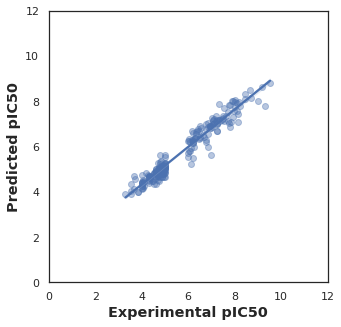

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Y_test, y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show

#### 3. Using lazy predict

In [58]:
! pip install lazypredict

     |████████████████████████████████| 25.9 MB 958 bytes/s 
     |████████████████████████████████| 82 kB 976 kB/s 
     |████████████████████████████████| 127.6 MB 23 kB/s 
     |████████████████████████████████| 6.8 MB 33.7 MB/s 
     |████████████████████████████████| 248 kB 46.6 MB/s 
     |████████████████████████████████| 302 kB 43.2 MB/s 
     |████████████████████████████████| 72 kB 900 kB/s 
     |████████████████████████████████| 1.2 MB 31.7 MB/s 
     |████████████████████████████████| 269 kB 48.7 MB/s 
     |████████████████████████████████| 10.1 MB 32.3 MB/s 
     |████████████████████████████████| 14.5 MB 8.1 kB/s 
     |████████████████████████████████| 40 kB 4.5 MB/s 
     |████████████████████████████████| 53 kB 2.2 MB/s 
     |████████████████████████████████| 97 kB 5.9 MB/s 
     |████████████████████████████████| 51 kB 260 kB/s 
     |████████████████████████████████| 67 kB 5.4 MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size

In [59]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import lazypredict
from lazypredict.Supervised import LazyRegressor

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [60]:
# Remove low variance features
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
input = selection.fit_transform(input)
input.shape

(716, 196)

In [61]:
# Defines and builds the lazyregressor
clf = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
models_train,predictions_train = clf.fit(X_train, X_train, Y_train, Y_train)
models_test,predictions_test = clf.fit(X_train, X_test, Y_train, Y_test)

 92%|█████████▏| 35/38 [00:21<00:01,  2.84it/s]

[11:25:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 38/38 [00:00<00:00, 171564.64it/s]


In [62]:
predictions_train

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
DecisionTreeRegressor,0.94,0.96,0.29,0.07
ExtraTreeRegressor,0.94,0.96,0.29,0.04
ExtraTreesRegressor,0.94,0.96,0.29,1.12
GaussianProcessRegressor,0.94,0.96,0.29,0.13
RandomForestRegressor,0.89,0.93,0.41,0.95
MLPRegressor,0.87,0.92,0.43,1.32
BaggingRegressor,0.87,0.92,0.44,0.12
HistGradientBoostingRegressor,0.83,0.90,0.49,1.66
LGBMRegressor,0.83,0.90,0.49,0.19


In [63]:
predictions_test

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,


[(0.0, 1.0)]

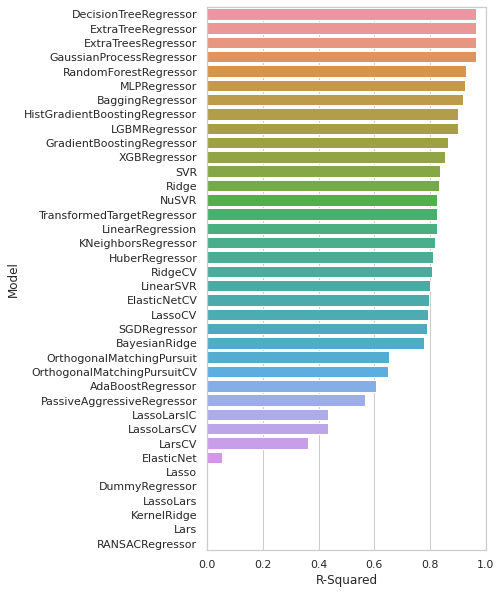

In [64]:
# Bar plot of R-squared values
import matplotlib.pyplot as plt
import seaborn as sns

#train["R-Squared"] = [0 if i < 0 else i for i in train.iloc[:,0] ]

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="R-Squared", data=predictions_train)
ax.set(xlim=(0, 1))

[(0.0, 10.0)]

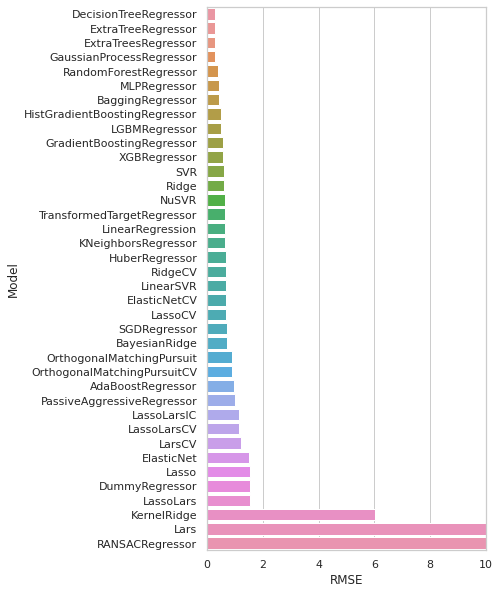

In [65]:
# Bar plot of RMSE values
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="RMSE", data=predictions_train)
ax.set(xlim=(0, 10))

[(0.0, 10.0)]

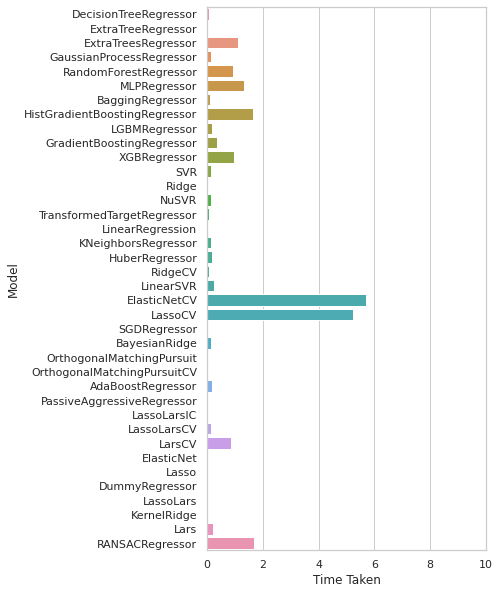

In [66]:
# Bar plot of calculation time
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="Time Taken", data=predictions_train)
ax.set(xlim=(0, 10))